In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import sklearn
import matplotlib.pyplot as plt
import torchvision

In [2]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        # Input: N x channels_img, x 64 x 64
        self.disc = nn.Sequential(
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ), # out: 32 x 32
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d*2, 4, 2, 1), # 16x16
            self._block(features_d*2, features_d*4, 4, 2, 1), #8x8
            self._block(features_d*4, features_d*8, 4, 2, 1), #4x4
            nn.Conv2d(features_d*8, 1, kernel_size=4, stride=2, padding=0), # 1x1 
            nn.Sigmoid() # If its fake or real
        )
        
    def forward(self, x):
        return self.disc(x)
        
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

In [3]:
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            # Input: N x z_dim x 1 x1 
            self._block(z_dim, features_g*16, 4, 1, 0), # out: N x features_g*16 x 4 x4
            self._block(features_g*16,features_g*8, 4, 2, 1), # 8x8
            self._block(features_g*8,features_g*4, 4, 2, 1), # 16x16
            self._block(features_g*4,features_g*2, 4, 2, 1), # 32x32
            nn.ConvTranspose2d(
                features_g*2, channels_img, kernel_size=4, stride=2, padding=1,
            ),
            nn.Tanh(), #[-1, 1]
        )
    
    def forward(self, x):
        return self.gen(x)
    
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, 
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

In [4]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [5]:
def test():
    N, in_channels, H, W = 8, 3, 64, 64
    z_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    gen = Generator(z_dim, in_channels, 8)
    initialize_weights(disc)
    initialize_weights(gen)
    assert disc(x).shape == (N,1,1,1)
    z = torch.randn((N, z_dim, 1, 1))
    assert gen(z).shape == (N, in_channels, H, W)

In [6]:
test()

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LEARNING_RATE = 2e-4
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 1
Z_DIM = 100
NUM_EPOCHS = 10
FEATURES_DISC = 64
FEATURES_GEN = 64

In [8]:
transforms = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
#         transforms.Normalize([0.5 in range(CHANNELS_IMG)], [0.5 in range(CHANNELS_IMG)])
    ])

In [9]:
dataset = datasets.MNIST(root='dataset/', train=True, transform=transforms, download=True)
loader = DataLoader(dataset, batch_size= BATCH_SIZE, shuffle= True)
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)

100%|██████████| 9912422/9912422 [00:00<00:00, 212901978.40it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 53838086.14it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 344708737.31it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 8311749.03it/s]


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [10]:
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr= LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()


In [11]:
fixed_noise = torch.randn(32, Z_DIM, 1,1 ).to(device)

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch [0]


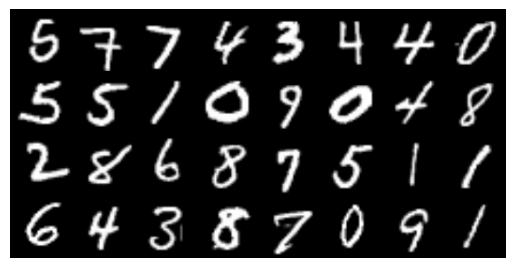

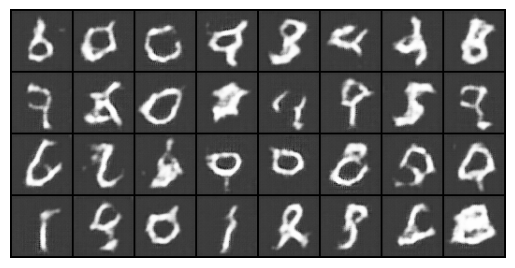

Epoch [1]:   0%|          | 1/469 [00:00<01:30,  5.17it/s, loss_D=0.662, loss_G=0.786]

Epoch [1]


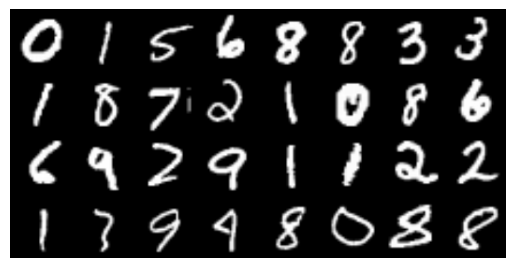

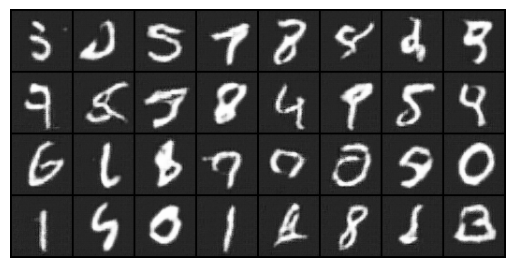

Epoch [2]:   0%|          | 1/469 [00:00<01:31,  5.11it/s, loss_D=0.492, loss_G=1.24]

Epoch [2]


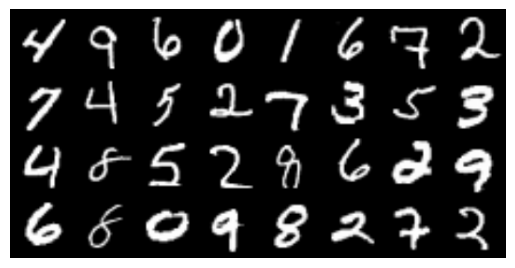

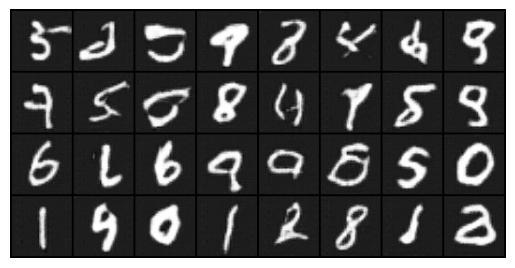

Epoch [3]:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch [3]


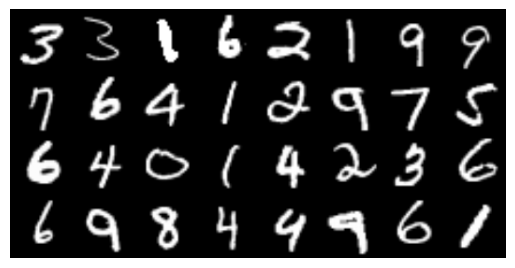

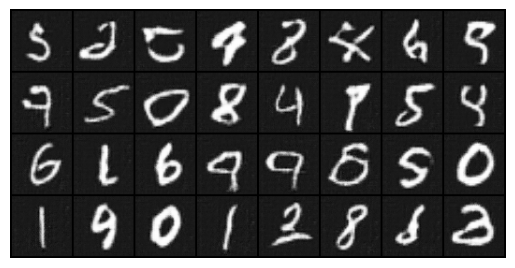

Epoch [4]:   0%|          | 1/469 [00:00<01:29,  5.20it/s, loss_D=0.371, loss_G=1.99]

Epoch [4]


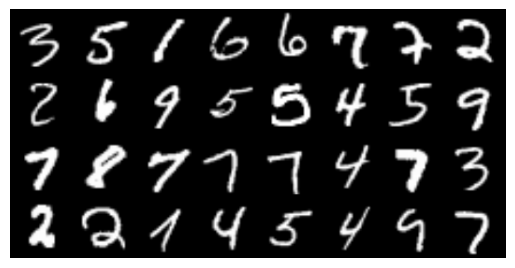

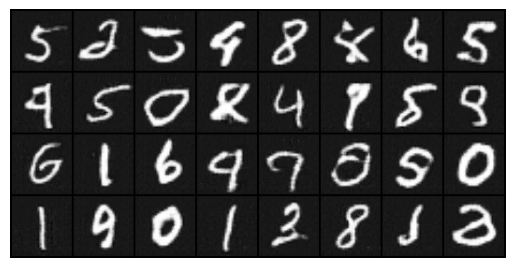

Epoch [5]:   0%|          | 1/469 [00:00<01:31,  5.14it/s, loss_D=0.948, loss_G=1.06]

Epoch [5]


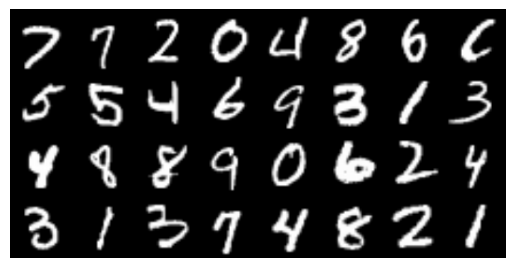

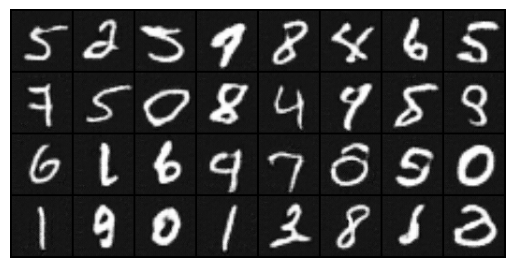

Epoch [6]:   0%|          | 1/469 [00:00<01:31,  5.09it/s, loss_D=0.158, loss_G=2.69]

Epoch [6]


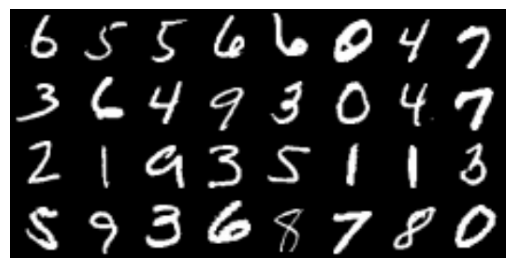

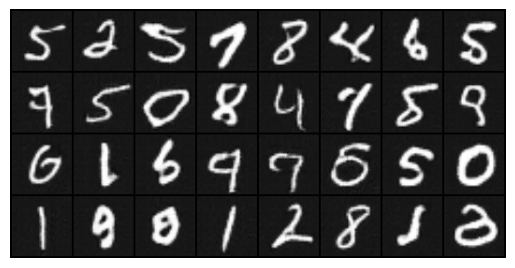

Epoch [7]:   0%|          | 1/469 [00:00<01:29,  5.21it/s, loss_D=0.671, loss_G=4.24]

Epoch [7]


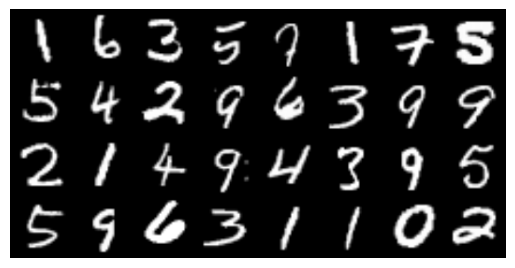

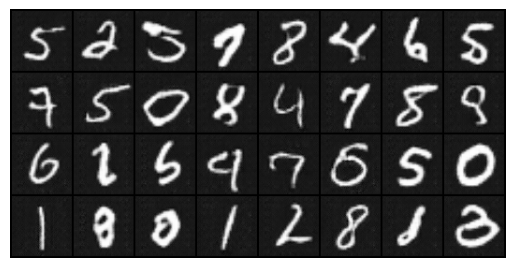

Epoch [8]:   0%|          | 1/469 [00:00<01:32,  5.06it/s, loss_D=0.184, loss_G=4.61]

Epoch [8]


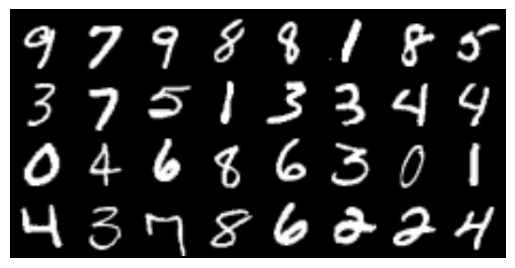

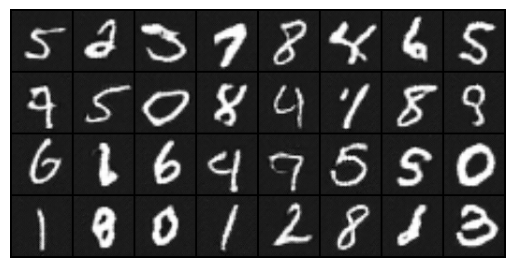

Epoch [9]:   0%|          | 1/469 [00:00<01:33,  5.01it/s, loss_D=0.478, loss_G=1.51]

Epoch [9]


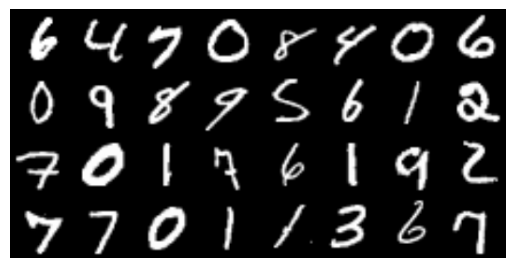

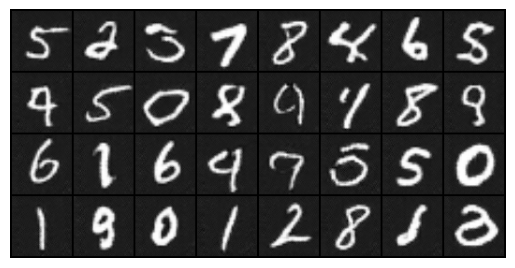

In [12]:
for epoch in range(NUM_EPOCHS):
    runningLoss = 0.0
    gen.train()
    disc.train()
    loop = tqdm(enumerate(loader), total= len(loader), leave= False)
    print(f'Epoch [{epoch}]')
    for batch_idx, (real, _) in loop:
        real = real.to(device)
        noise = torch.randn((BATCH_SIZE, Z_DIM, 1, 1)).to(device)
        fake = gen(noise)
        
        ### Train Discriminator max log(D(X) + log(1 - D(G(z))))
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake)/2
        disc.zero_grad()
        loss_disc.backward(retain_graph=True)
        opt_disc.step()
        
        
        # train Generator min log(1- D(G(Z)))
        output= disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()
        
        loop.set_description(f'Epoch [{epoch}]')
        loop.set_postfix(loss_D = loss_disc.item(),loss_G = loss_gen.item() )
        
    
    with torch.no_grad():
        fake = gen(fixed_noise)
        img_grid_real = torchvision.utils.make_grid(
        real[:32], normalize=True)
        img_grid_fake = torchvision.utils.make_grid(
        fake[:32], normalize=True
        )

        img_grid_real = img_grid_real.permute(1, 2, 0).cpu().numpy()
        img_grid_fake = img_grid_fake.permute(1, 2, 0).cpu().numpy()


        plt.imshow(img_grid_real)
        plt.axis('off')
        plt.show()
        
        plt.imshow(img_grid_fake)
        plt.axis('off')
        plt.show()

# Adpat to CELEB DATASET

In [13]:
CHANNELS_IMG = 3

In [14]:
import torchvision.transforms as transforms
transforms = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

In [15]:
dataset = datasets.ImageFolder(root='/kaggle/input/celeba-dataset', transform=transforms)

In [16]:
loader = DataLoader(dataset, batch_size= BATCH_SIZE, shuffle= True)
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)

In [17]:
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr= LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()

  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [0]


Epoch [0]:  63%|██████▎   | 1000/1583 [17:48<10:27,  1.08s/it, loss_D=0.604, loss_G=1.08]

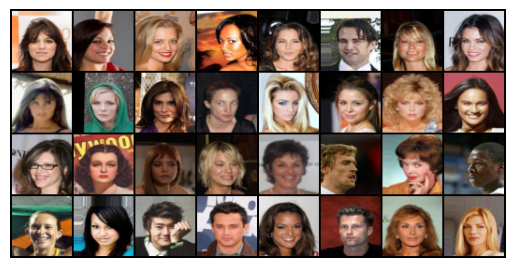

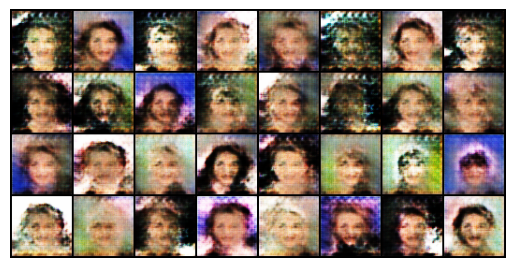

  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [1]


Epoch [1]:  63%|██████▎   | 1000/1583 [07:59<04:56,  1.97it/s, loss_D=0.673, loss_G=1.17]

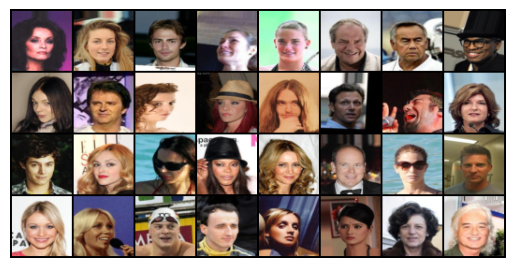

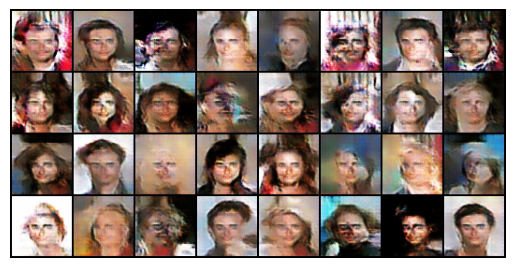

  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [2]


Epoch [2]:  63%|██████▎   | 1000/1583 [07:31<04:25,  2.20it/s, loss_D=0.464, loss_G=1.33]

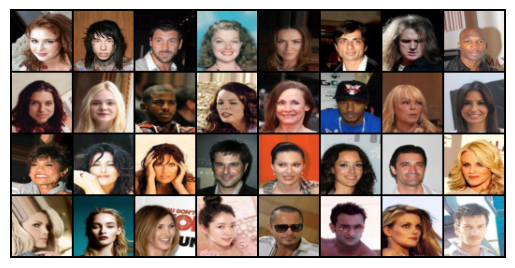

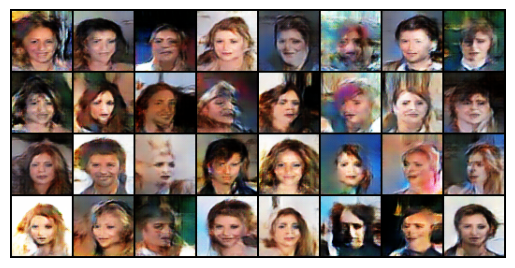

  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [3]


Epoch [3]:  63%|██████▎   | 1000/1583 [07:37<04:58,  1.95it/s, loss_D=0.585, loss_G=1.95]

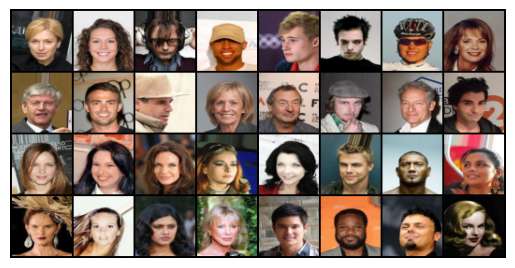

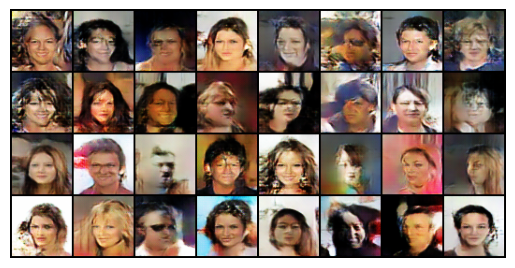

  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [4]


Epoch [4]:  63%|██████▎   | 1000/1583 [07:35<04:30,  2.16it/s, loss_D=0.597, loss_G=2.35] 

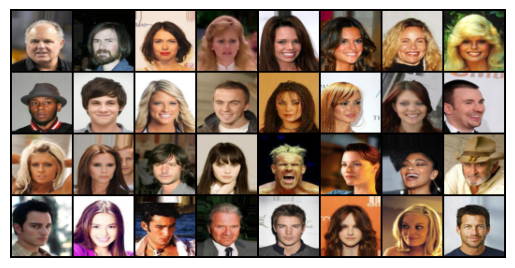

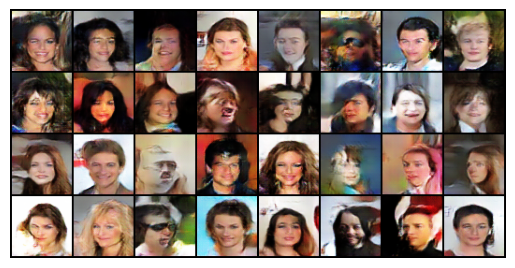

  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [5]


Epoch [5]:  63%|██████▎   | 1000/1583 [07:31<04:28,  2.17it/s, loss_D=0.488, loss_G=2.61]

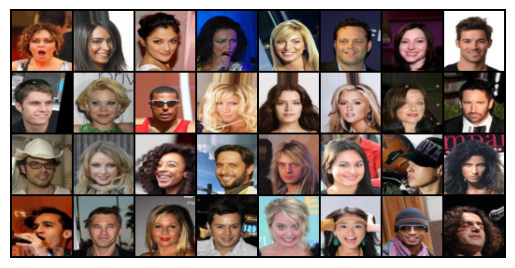

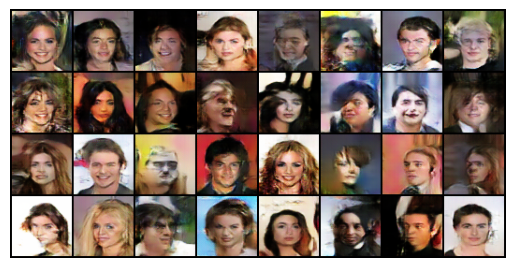

  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [6]


Epoch [6]:  63%|██████▎   | 1000/1583 [07:34<04:44,  2.05it/s, loss_D=0.446, loss_G=0.939]

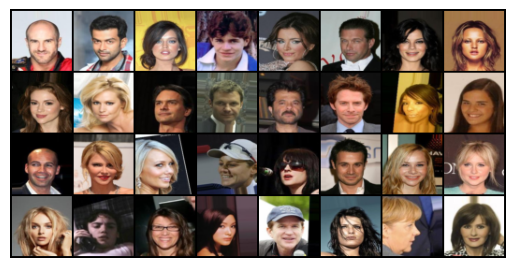

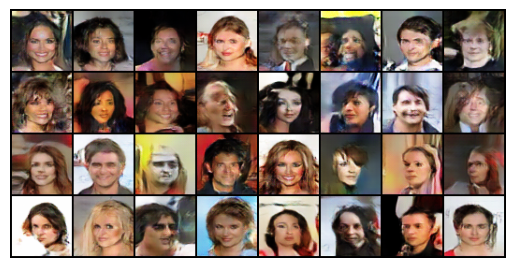

  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [7]


Epoch [7]:  63%|██████▎   | 1000/1583 [07:52<05:13,  1.86it/s, loss_D=0.487, loss_G=0.817]

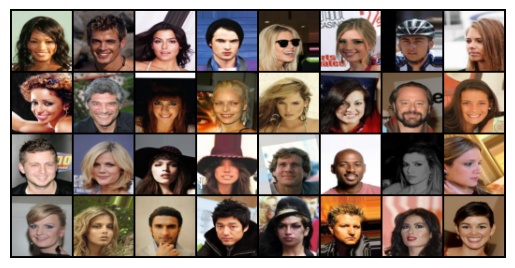

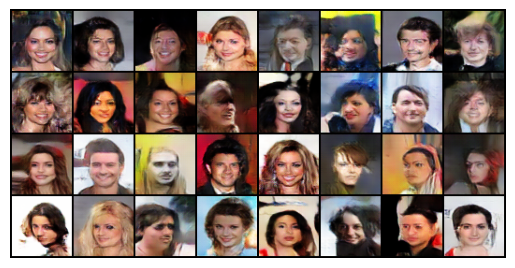

  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [8]


Epoch [8]:  63%|██████▎   | 1000/1583 [48:26<42:37,  4.39s/it, loss_D=0.425, loss_G=1.12]

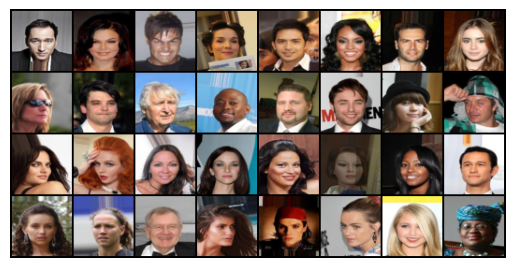

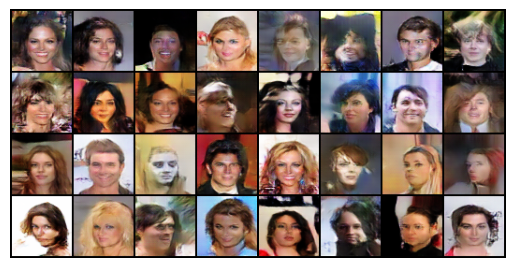

  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [9]


Epoch [9]:  63%|██████▎   | 1000/1583 [21:29<13:48,  1.42s/it, loss_D=0.265, loss_G=2.01]

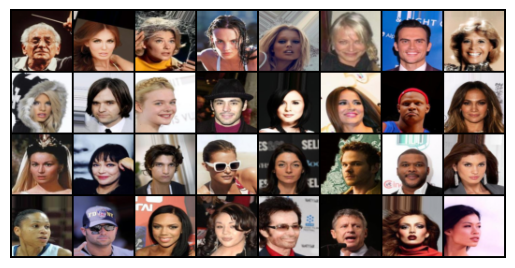

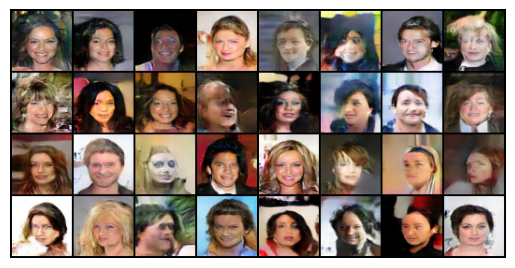

In [18]:
NUM_EPOCHS = 10
for epoch in range(NUM_EPOCHS):
    runningLoss = 0.0
    gen.train()
    disc.train()
    loop = tqdm(enumerate(loader), total= len(loader), leave= False)
    print(f'Epoch [{epoch}]')
    for batch_idx, (real, _) in loop:
        real = real.to(device)
        noise = torch.randn((BATCH_SIZE, Z_DIM, 1, 1)).to(device)
        fake = gen(noise)
        
        ### Train Discriminator max log(D(X) + log(1 - D(G(z))))
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake)/2
        disc.zero_grad()
        loss_disc.backward(retain_graph=True)
        opt_disc.step()
        
        
        # train Generator min log(1- D(G(Z)))
        output= disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()
        
        loop.set_description(f'Epoch [{epoch}]')
        loop.set_postfix(loss_D = loss_disc.item(),loss_G = loss_gen.item() )
        
        if batch_idx % 1000 == 0 and batch_idx != 0:
             with torch.no_grad():
                fake = gen(fixed_noise)
                img_grid_real = torchvision.utils.make_grid(
                real[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(
                fake[:32], normalize=True
                )

                img_grid_real = img_grid_real.permute(1, 2, 0).cpu().numpy()
                img_grid_fake = img_grid_fake.permute(1, 2, 0).cpu().numpy()


                plt.imshow(img_grid_real)
                plt.axis('off')
                plt.show()

                plt.imshow(img_grid_fake)
                plt.axis('off')
                plt.show()

   